          R         F         M  类别数目
0 -0.149254 -0.660412 -0.272527   559
1 -0.160580  1.112094  0.392121   341
2  3.455055 -0.295654  0.449123    40


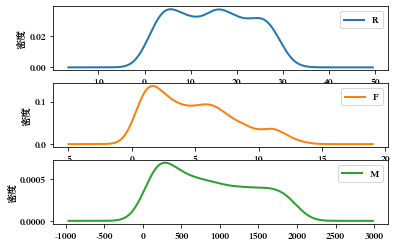

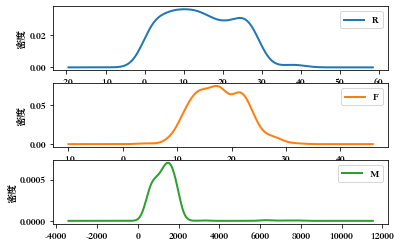

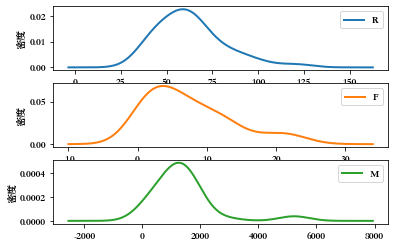

In [1]:
#k-means
# -*- coding: utf-8 -*-
import warnings 
warnings.filterwarnings("ignore")
import pandas as pd
# 参数初始化
inputfile = '../data/consumption_data.xls'  # 销量及其他属性数据
outputfile = '../tmp/data_type.xls'  # 保存结果的文件名
k = 3  # 聚类的类别
iteration = 500  # 聚类最大循环次数
data = pd.read_excel(inputfile, index_col = 'Id')  # 读取数据
data_zs = 1.0*(data - data.mean())/data.std()  # 数据标准化

from sklearn.cluster import KMeans
model = KMeans(n_clusters = k, n_jobs = 4, max_iter = iteration,random_state=1234)  # 分为k类，并发数4
model.fit(data_zs)  # 开始聚类

# 简单打印结果
r1 = pd.Series(model.labels_).value_counts()  # 统计各个类别的数目
r2 = pd.DataFrame(model.cluster_centers_)  # 找出聚类中心
r = pd.concat([r2, r1], axis = 1)  # 横向连接（0是纵向），得到聚类中心对应的类别下的数目
r.columns = list(data.columns) + ['类别数目']  # 重命名表头
print(r)

# 详细输出原始数据及其类别
r = pd.concat([data, pd.Series(model.labels_, index = data.index)], axis = 1)   # 详细输出每个样本对应的类别
r.columns = list(data.columns) + ['聚类类别']  # 重命名表头
r.to_csv(outputfile)  # 保存结果
# r.to_excle(outputfile)  # 保存结果

def density_plot(data):  # 自定义作图函数
  import matplotlib.pyplot as plt
  plt.rcParams['font.sans-serif'] = ['Songti SC']  # 用来正常显示中文标签
  plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
  p = data.plot(kind='kde', linewidth = 2, subplots = True, sharex = False)
  [p[i].set_ylabel('密度') for i in range(k)]
  plt.legend()
  return plt

pic_output = '../tmp/pd'  # 概率密度图文件名前缀
for i in range(k):
  density_plot(data[r['聚类类别']==i]).savefig('%s%s.png' %(pic_output, i))
 

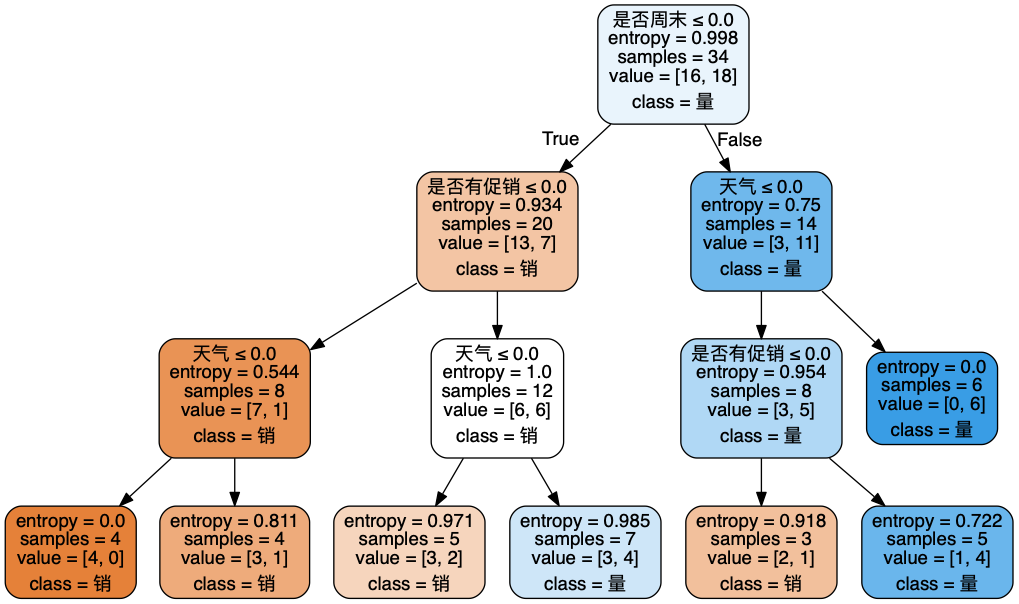

In [16]:
# decision_tree.py
import pandas as pd
# 参数初始化
filename = '../data/sales_data.xls'
data = pd.read_excel(filename, index_col = '序号')  # 导入数据

# 数据是类别标签，要将它转换为数据
# 用1来表示“好”“是”“高”这三个属性，用-1来表示“坏”“否”“低”
data[data == '好'] = 1
data[data == '是'] = 1
data[data == '高'] = 1
data[data != 1] = -1
x = data.iloc[:,:3].astype(int)
y = data.iloc[:,3].astype(int)


from sklearn.tree import DecisionTreeClassifier as DTC
dtc = DTC(criterion='entropy')  # 建立决策树模型，基于信息熵
dtc.fit(x, y)  # 训练模型

# 导入相关函数，可视化决策树。
# 导出的结果是一个dot文件，需要安装Graphviz才能将它转换为pdf或png等格式。
from sklearn.tree import export_graphviz
x = pd.DataFrame(x)

# """
string1 = '''
edge [fontname="Songti SC"];
node [ fontname="Songti SC" size="15,15"];
{
 ''' 
string2 = '}'
# """
 
with open("../tmp/tree.dot", 'w') as f:
    export_graphviz(dtc, feature_names = x.columns, out_file = f)
    f.close()



# '''
from IPython.display import Image  
from sklearn import tree
import pydotplus 

dot_data = tree.export_graphviz(dtc, out_file=None,  #regr_1 是对应分类器
                         feature_names=data.columns[:3],   #对应特征的名字
                         class_names=data.columns[3],    #对应类别的名字
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
graph.write_png('../tmp/example.png')    #保存图像
Image(graph.create_png()) 
# '''

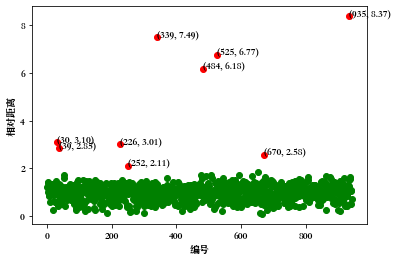

In [3]:
#  discrete_point_test.py
import numpy as np
import pandas as pd

# 参数初始化
inputfile = '../data/consumption_data.xls'  # 销量及其他属性数据
k = 3  # 聚类的类别
threshold = 2  # 离散点阈值
iteration = 500  # 聚类最大循环次数
data = pd.read_excel(inputfile, index_col = 'Id')  # 读取数据
data_zs = 1.0*(data - data.mean())/data.std()  # 数据标准化

from sklearn.cluster import KMeans
model = KMeans(n_clusters = k, n_jobs = 4, max_iter = iteration)  # 分为k类，并发数4
model.fit(data_zs)  # 开始聚类

# 标准化数据及其类别
r = pd.concat([data_zs, pd.Series(model.labels_, index = data.index)], axis = 1)   # 每个样本对应的类别
r.columns = list(data.columns) + ['聚类类别']  # 重命名表头

norm = []
for i in range(k):  # 逐一处理
  norm_tmp = r[['R', 'F', 'M']][r['聚类类别'] == i]-model.cluster_centers_[i]
  norm_tmp = norm_tmp.apply(np.linalg.norm, axis = 1)  # 求出绝对距离
  norm.append(norm_tmp/norm_tmp.median())  # 求相对距离并添加

norm = pd.concat(norm)  # 合并

import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Songti SC']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
norm[norm <= threshold].plot(style = 'go')  # 正常点

discrete_points = norm[norm > threshold]  # 离群点
discrete_points.plot(style = 'ro')

for i in range(len(discrete_points)):  # 离群点做标记
  id = discrete_points.index[i]
  n = discrete_points.iloc[i]
  plt.annotate('(%s, %0.2f)'%(id, n), xy = (id, n), xytext = (id, n))

plt.xlabel('编号')
plt.ylabel('相对距离')
plt.show()

Epoch 1/100
4/4 [==============================] - 1s 4ms/step - loss: 0.6394
Epoch 2/100
4/4 [==============================] - 0s 12ms/step - loss: 0.6378
Epoch 3/100
4/4 [==============================] - 0s 27ms/step - loss: 0.6367
Epoch 4/100
4/4 [==============================] - 0s 16ms/step - loss: 0.6358
Epoch 5/100
4/4 [==============================] - 0s 13ms/step - loss: 0.6349
Epoch 6/100
4/4 [==============================] - 0s 4ms/step - loss: 0.6337
Epoch 7/100
4/4 [==============================] - 0s 34ms/step - loss: 0.6327
Epoch 8/100
4/4 [==============================] - 0s 12ms/step - loss: 0.6317
Epoch 9/100
4/4 [==============================] - 0s 32ms/step - loss: 0.6309
Epoch 10/100
4/4 [==============================] - 0s 21ms/step - loss: 0.6299
Epoch 11/100
4/4 [==============================] - 0s 9ms/step - loss: 0.6290
Epoch 12/100
4/4 [==============================] - 0s 3ms/step - loss: 0.6279
Epoch 13/100
4/4 [==============================] - 0

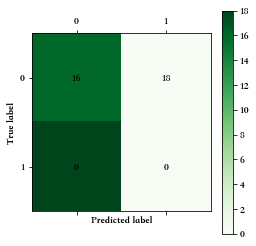

In [4]:
# neural_network.py
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
# 参数初始化
inputfile = '../data/sales_data.xls'
data = pd.read_excel(inputfile, index_col = '序号')  # 导入数据

# 数据是类别标签，要将它转换为数据
# 用1来表示“好”“是”“高”这三个属性，用0来表示“坏”“否”“低”
data[data == '好'] = 1
data[data == '是'] = 1
data[data == '高'] = 1
data[data != 1] = 0
x = data.iloc[:,:3].astype(int)
y = data.iloc[:,3].astype(int)

from keras.models import Sequential
from keras.layers.core import Dense, Activation

model = Sequential()  # 建立模型
model.add(Dense(input_dim = 3, units = 10))
model.add(Activation('relu'))  # 用relu函数作为激活函数，能够大幅提供准确度
model.add(Dense(input_dim = 10, units = 1))
model.add(Activation('sigmoid'))  # 由于是0-1输出，用sigmoid函数作为激活函数

model.compile(loss = 'binary_crossentropy', optimizer = 'adam')
# 编译模型。由于我们做的是二元分类，所以我们指定损失函数为binary_crossentropy，以及模式为binary
# 另外常见的损失函数还有mean_squared_error、categorical_crossentropy等，请阅读帮助文件。
# 求解方法我们指定用adam，还有sgd、rmsprop等可选

model.fit(x, y, epochs = 100, batch_size = 10)  # 训练模型，学习一千次
# yp = model.predict_classes(x).reshape(len(y))  # 分类预测
yp = np.argmax(model.predict(x),axis=-1)

from cm_plot import *  # 导入自行编写的混淆矩阵可视化函数
cm_plot(y,yp).show()  # 显示混淆矩阵可视化结果
# print ('abc')
 

In [14]:
# -*- coding: utf-8 -*-
# cal_apriori.py
from __future__ import print_function
import pandas as pd
from apriori import *  # 导入自行编写的apriori函数

inputfile = '../data/menu_orders.xls'
outputfile = '../tmp/apriori_rules.xls'  # 结果文件
data = pd.read_excel(inputfile, header = None)

print('\n转换原始数据至0-1矩阵...')
ct = lambda x : pd.Series(1, index = x[pd.notnull(x)])  # 转换0-1矩阵的过渡函数
b = map(ct, data.iloc[:,:].values)  # 用map方式执行
# b = map(ct, data.as_matrix())  # 用map方式执行
data = pd.DataFrame(list(b)).fillna(0)  # 实现矩阵转换，空值用0填充
print('\n转换完毕。')
del b  # 删除中间变量b，节省内存

support = 0.2  # 最小支持度
confidence = 0.5  # 最小置信度
ms = '---'  # 连接符，默认'--'，用来区分不同元素，如A--B。需要保证原始表格中不含有该字符

find_rule(data, support, confidence, ms).to_excel(outputfile)  # 保存结果




转换原始数据至0-1矩阵...

转换完毕。

正在进行第1次搜索...
数目：6...


AttributeError: 'Series' object has no attribute 'append'

In [13]:
# logistic_regression.py
import pandas as pd
from sklearn.linear_model import LogisticRegression as LR
# 参数初始化
filename = '../data/bankloan.xls'
data = pd.read_excel(filename)
# x = data.iloc[:,:8].as_matrix()
# y = data.iloc[:,8].as_matrix()
x = data.iloc[:,:8].values
y = data.iloc[:,8].values

lr = LR()  # 建立逻辑回归模型
lr.fit(x, y)  # 用筛选后的特征数据来训练模型
print('模型的平均准确度为：%s' % lr.score(x, y))



模型的平均准确度为：0.8085714285714286


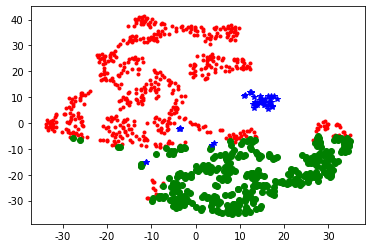

In [13]:
# tsne.py
import pandas as pd
from sklearn.manifold import TSNE
# 参数初始化
inputfile = '../data/consumption_data.xls'  # 销量及其他属性数据
inputfile1 = '../tmp/data_type.xls'  
data = pd.read_excel(inputfile, index_col = 'Id')  # 读取数据
data_zs = 1.0*(data - data.mean())/data.std() 
r = pd.read_excel(inputfile1,index_col='Id')

tsne = TSNE(random_state=105)
tsne.fit_transform(data_zs)  # 进行数据降维
tsne = pd.DataFrame(tsne.embedding_, index = data_zs.index)  # 转换数据格式

import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

# 不同类别用不同颜色和样式绘图
d = tsne[r['聚类类别'] == 0]
plt.plot(d[0], d[1], 'r.')
d = tsne[r['聚类类别'] == 1]
plt.plot(d[0], d[1], 'go')
d = tsne[r['聚类类别'] == 2]
plt.plot(d[0], d[1], 'b*')
plt.show()